<a href="https://colab.research.google.com/github/jacobalmon/CS-478/blob/main/Homework/Homework%203/hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from google.colab import drive

In [22]:
# Mounting Google Drive.
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [23]:
# Task 1: Data Preparation
# Load the CIFAR-10 Dataset.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize Pixel Values to [0 , 1].
x_train = x_train.astype("float32") / 255.0
x_test= x_test.astype("float32") / 255.0

In [24]:
# Task 2: Model Design.
# Load EfficientNetB0 with Pretrained ImageNet Weights w/o Top Classification.
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze Pretrained Layers.
base_model.trainable = False

# Build Model.
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(), # Reduce to a Single Vector.
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'), # Dense Layer.
    layers.Dropout(0.2), # Prevent Overfitting.
    layers.Dense(10, activation='softmax') # CIFAR-10 Output (10 Classes Total).
])

# Compile  Model.
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary of Model.
model.summary()

# Testing. (Delete Later)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 1, 1, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,385,197 (16.73 MB)

 Trainable params: 333,066 (1.27 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [25]:
# Task 3: Training.
# Data Augmentation.
data_gen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Initialize Epochs & Batch Size.
epochs_init = 5
epoch_finetune = 15
batch_size = 64

# Training Custom Classification Layer.
history_init = model.fit(
    data_gen.flow(x_train, y_train, batch_size=batch_size),
    validation_data=(x_test, y_test),
    epochs=epochs_init,
    verbose=1
)

# Unfreeze Layers & Fine Tune Model.
base_model.trainable = True

# Compile Model.
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train for Additioonal 15 Epochs.
history_finetune = model.fit(
    data_gen.flow(x_train, y_train, batch_size=batch_size),
    validation_data=(x_test, y_test),
    epochs=epoch_finetune,
    verbose=1
)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


782/782 ━━━━━━━━━━━━━━━━━━━━ 77s 69ms/step - accuracy: 0.1086 - loss: 2.4907 - val_accuracy: 0.1026 - val_loss: 2.3004
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 34s 43ms/step - accuracy: 0.1225 - loss: 2.2886 - val_accuracy: 0.1067 - val_loss: 2.2918
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.1296 - loss: 2.2754 - val_accuracy: 0.1112 - val_loss: 2.2831
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 34s 43ms/step - accuracy: 0.1399 - loss: 2.2597 - val_accuracy: 0.1113 - val_loss: 2.2848
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.1472 - loss: 2.2487 - val_accuracy: 0.1356 - val_loss: 2.2722
Epoch 1/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 157s 106ms/step - accuracy: 0.3544 - loss: 1.8284 - val_accuracy: 0.1407 - val_loss: 2.4710
Epoch 2/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 43s 55ms/step - accuracy: 0.6267 - loss: 1.0817 - val_accuracy: 0.1272 - val_loss: 2.6539
Epoch 3/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 54ms/step - accuracy: 0.6946 - loss: 0.9032 - val_accuracy:

In [29]:
# Save the Model.
model.save('/content/drive/MyDrive/cs478_model_hw3.keras')

In [30]:
# Load the Model
model = load_model('/content/drive/MyDrive/cs478_model_hw3.keras')

313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.1674 - loss: 3.6517
Test Accuracy: 0.1720999926328659


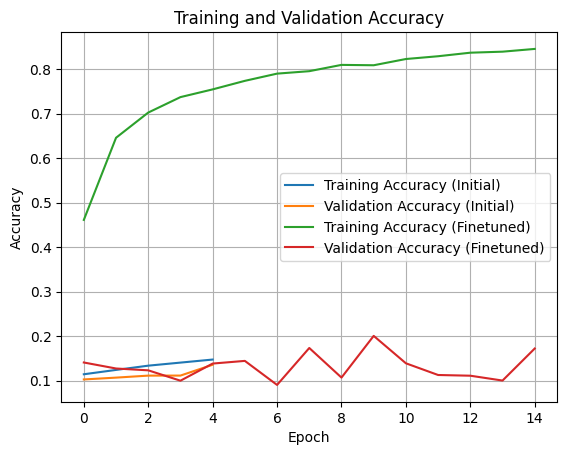

In [31]:
# Evaluating the model on the testing set
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc}")

# Plot Training & Validation Accuracy for both phases
plt.plot(history_init.history['accuracy'], label='Training Accuracy (Initial)')
plt.plot(history_init.history['val_accuracy'], label='Validation Accuracy (Initial)')
plt.plot(history_finetune.history['accuracy'], label='Training Accuracy (Finetuned)')
plt.plot(history_finetune.history['val_accuracy'], label='Validation Accuracy (Finetuned)')

# Adding labels and title to the plot
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Displaying the legend and the plot
plt.legend()
plt.grid(True)
plt.show()